In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

### Auditoría rápida + llaves + limpieza mínima

Validamos y estandarizamos los 3 CSV por trimestre (reports/drugs/reactions) para que se puedan unir y dejar listo el dataset.

In [7]:
base = Path("data_processed/q1_2025_sample100k")

reports = pd.read_csv(base/"q1_reports_100k.csv", dtype={"safetyreportid":"string"})
drugs = pd.read_csv(base/"q1_drugs_100k.csv", dtype={"safetyreportid":"string"})
reactions = pd.read_csv(base/"q1_reactions_100k.csv", dtype={"safetyreportid":"string"})

print("filas:", {"reports": len(reports), "drugs": len(drugs), "reactions": len(reactions)})
print("ID's únicos en los informes:", reports["safetyreportid"].nunique())
print("tasas de identificación nula:", {
    "reports": reports["safetyreportid"].isna().mean(),
    "drugs": drugs["safetyreportid"].isna().mean(),
    "reactions": reactions["safetyreportid"].isna().mean(),
})

# IDs en drugs/reactions que no están en reports 
print("Medicamentos que no aparecen en los informes:", (~drugs["safetyreportid"].isin(reports["safetyreportid"])).sum())
print("Reacciones que no aparecen en los informes:", (~reactions["safetyreportid"].isin(reports["safetyreportid"])).sum())

# Limpieza mínima de strings
for col in ["medicinalproduct", "activesubstancename"]:
    if col in drugs.columns:
        drugs[col] = drugs[col].astype("string").str.strip().str.upper()

reactions["reaction_pt"] = reactions["reaction_pt"].astype("string").str.strip().str.upper()

# Definir D (drug_key): activo si existe, si no producto
drugs["drug_key"] = drugs["activesubstancename"].fillna(drugs["medicinalproduct"]).astype("string").str.strip().str.upper()

# Deduplicar por reporte para no contar múltiples veces lo mismo
drugs_u = drugs[["safetyreportid","drug_key"]].dropna().drop_duplicates()
reac_u  = reactions[["safetyreportid","reaction_pt"]].dropna().drop_duplicates()

print("filas de medicamentos únicos:", len(drugs_u))
print("filas de reacción únicas:", len(reac_u))

filas: {'reports': 100000, 'drugs': 518895, 'reactions': 355420}
ID's únicos en los informes: 100000
tasas de identificación nula: {'reports': 0.0, 'drugs': 0.0, 'reactions': 0.0}
Medicamentos que no aparecen en los informes: 0
Reacciones que no aparecen en los informes: 0
filas de medicamentos únicos: 327778
filas de reacción únicas: 350884


## Análisis Exploratorio de Datos

#### Cobertura por reporte

La cobertura por reporte (contar #drugs por report y #reactions por report) se hace para entender qué tan “cargados” vienen los reportes y cómo eso puede afectar el análisis de señales.

En FAERS, un “reporte” (safetyreportid) puede listar muchos medicamentos (los que el paciente tomaba, sospechosos, concomitantes, etc.) y muchas reacciones (síntomas/eventos reportados). La mayoría de reportes tiene pocos, pero algunos casos “complicados” traen decenas o cientos. A esos se les suele llamar reportes “monstruo”.

In [18]:
base = Path("data_processed/q1_2025_sample100k")

reports = pd.read_csv(base/"q1_reports_100k.csv", dtype={"safetyreportid":"string"})
drugs = pd.read_csv(base/"q1_drugs_100k.csv", dtype={"safetyreportid":"string"})
reactions = pd.read_csv(base/"q1_reactions_100k.csv", dtype={"safetyreportid":"string"})

# Limpieza mínima
for col in ["medicinalproduct", "activesubstancename"]:
    drugs[col] = drugs[col].astype("string").str.strip().str.upper()
reactions["reaction_pt"] = reactions["reaction_pt"].astype("string").str.strip().str.upper()

# Cobertura por reporte
drugs_u = drugs[["safetyreportid","activesubstancename","medicinalproduct"]].drop_duplicates()
reac_u  = reactions[["safetyreportid","reaction_pt"]].drop_duplicates()

drugs_per_report = drugs_u.groupby("safetyreportid").size()
reac_per_report  = reac_u.groupby("safetyreportid").size()

print("Drugs/report percentiles:\n", drugs_per_report.quantile([.5,.75,.9,.95,.99]))
print("Reactions/report percentiles:\n", reac_per_report.quantile([.5,.75,.9,.95,.99]))


Drugs/report percentiles:
 0.50     1.0
0.75     3.0
0.90     8.0
0.95    13.0
0.99    28.0
dtype: float64
Reactions/report percentiles:
 0.50     2.0
0.75     4.0
0.90     7.0
0.95    11.0
0.99    26.0
dtype: float64


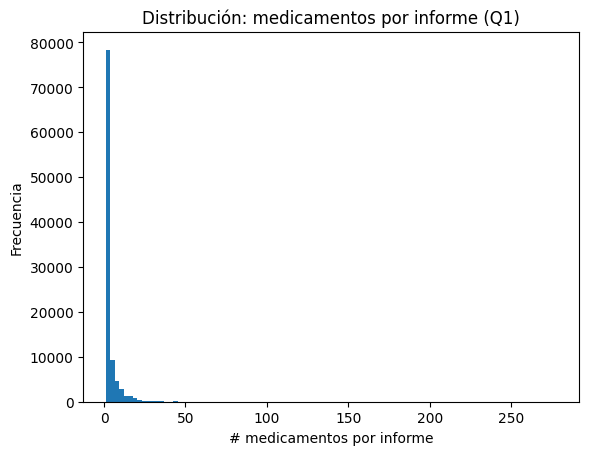

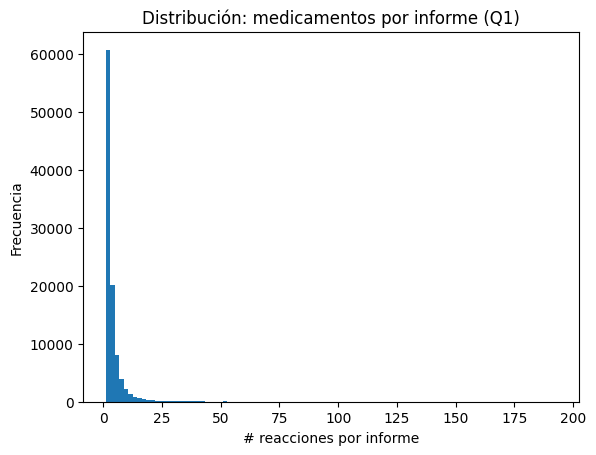

In [23]:
plt.figure()
plt.hist(drugs_per_report, bins=100)
plt.xlabel("# medicamentos por informe")
plt.ylabel("Frecuencia")
plt.title("Distribución: medicamentos por informe (Q1)")
#plt.ylim(0,100)
plt.show()

plt.figure()
plt.hist(reac_per_report, bins=100)
plt.xlabel("# reacciones por informe")
plt.ylabel("Frecuencia")
#plt.ylim(0,100)
plt.title("Distribución: medicamentos por informe (Q1)")
plt.show()

La distribución de **medicamentos por informe** y **reacciones por informe** es fuertemente asimétrica (cola larga). En la mayoría de los reportes se listan pocos elementos: la mediana es **1 medicamento** y **2 reacciones**; el **75%** de los reportes tiene **≤3 medicamentos** y **≤4 reacciones**. Aun así, existen reportes “grandes”: el **5%** superior llega a **≤13 medicamentos** y **≤11 reacciones** (p95), y el **1%** superior a **≤28 medicamentos** y **≤26 reacciones** (p99). Los histogramas muestran algunos valores extremos (muy raros) con decenas o cientos de registros. Estos outliers pueden **distorsionar el conteo de coocurrencias fármaco–evento** (generan muchos pares potenciales en un solo informe), por lo que conviene identificarlos y, en análisis de sensibilidad, evaluar si su presencia afecta las señales.


### Calidad de nombres

Se hace Calidad de nombres para asegurarte de que la “variable fármaco” (D) y, en menor medida, la “variable evento” (A) son comparables y consistentes antes de contar coocurrencias y calcular señales (PRR/ROR/IC).

En FAERS los nombres vienen con variaciones (marca vs genérico, mayúsculas, espacios, abreviaturas, “UNKNOWN”, etc.). Si no se revisa esto, se puede terminar contando como distintos lo que es lo mismo, o mezclando basura con datos reales.

In [25]:
active_nonnull = drugs["activesubstancename"].notna() & (drugs["activesubstancename"].str.len() > 0)
prod_nonnull   = drugs["medicinalproduct"].notna() & (drugs["medicinalproduct"].str.len() > 0)

print("Filas de fracciones con nombre de sustancia activa:", active_nonnull.mean())
print("Filas de fracciones con medicamento:", prod_nonnull.mean())

top_active = drugs.loc[active_nonnull, "activesubstancename"].value_counts().head(20)
top_prod   = drugs.loc[prod_nonnull, "medicinalproduct"].value_counts().head(20)

print("\nTop-20 sustancias activas:")
display(top_active)

print("\nTop-20 productos medicinales:")
display(top_prod)


Filas de fracciones con nombre de sustancia activa: 0.9840449416548628
Filas de fracciones con medicamento: 1.0

Top-20 sustancias activas:


activesubstancename
TIRZEPATIDE                 13065
DUPILUMAB                   12066
INFLIXIMAB-DYYB              8464
PREDNISONE                   7423
INFLIXIMAB                   6593
METHOTREXATE                 6146
ACETAMINOPHEN                6043
VEDOLIZUMAB                  5556
TOCILIZUMAB                  5415
RITUXIMAB                    5164
ADALIMUMAB                   4742
OMALIZUMAB                   4056
CETIRIZINE HYDROCHLORIDE     3814
SULFASALAZINE                3669
FOLIC ACID                   3485
ALBUTEROL SULFATE            3257
TOFACITINIB CITRATE          3120
ASPIRIN                      3047
HUMAN IMMUNOGLOBULIN G       3026
AMLODIPINE BESYLATE          3020
Name: count, dtype: Int64


Top-20 productos medicinales:


medicinalproduct
DUPIXENT             11869
INFLECTRA             8305
PREDNISONE            7377
MOUNJARO              7343
METHOTREXATE          6139
ZEPBOUND              5577
VEDOLIZUMAB           4843
RITUXIMAB             4809
ACTEMRA               4387
ACETAMINOPHEN         4281
SULFASALAZINE         3636
FOLIC ACID            3457
INFLIXIMAB            3447
REMICADE              3146
ASPIRIN               2995
ELIGARD               2704
OMALIZUMAB            2452
ALBUTEROL SULFATE     2435
HUMIRA                2429
ORENCIA               2425
Name: count, dtype: Int64

### Frecuencia y cola larga

Se hace frecuencia y cola larga para entender cómo están distribuidos los eventos (y fármacos) y cómo eso afecta la confiabilidad de las señales.

En FAERS casi siempre pasa esto: pocos términos aparecen muchísimo y muchísimos términos aparecen muy poco. Eso es la “cola larga”.


Top-20 reacciones (PT):


reaction_pt
OFF LABEL USE                                       8347
DRUG INEFFECTIVE                                    5798
FATIGUE                                             4786
PRODUCT DOSE OMISSION ISSUE                         4279
NAUSEA                                              3879
DIARRHOEA                                           3796
DEATH                                               3607
HEADACHE                                            3028
DYSPNOEA                                            2967
PAIN                                                2928
PRURITUS                                            2843
ARTHRALGIA                                          2684
RASH                                                2576
VOMITING                                            2574
CONDITION AGGRAVATED                                2528
INAPPROPRIATE SCHEDULE OF PRODUCT ADMINISTRATION    2392
PNEUMONIA                                           2339
DIZZINESS          

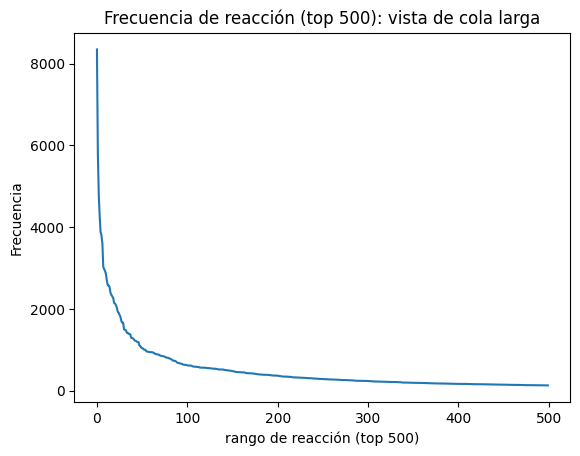

In [26]:
top_reac = reactions["reaction_pt"].value_counts()
print("\nTop-20 reacciones (PT):")
display(top_reac.head(20))

plt.figure()
plt.plot(top_reac.values[:500])
plt.xlabel("rango de reacción (top 500)")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de reacción (top 500): vista de cola larga")
plt.show()

#### Frecuencia de reacciones (cola larga)

La gráfica de frecuencia de reacciones (Top 500) muestra una distribución con cola larga: unas pocas reacciones concentran muchos reportes, y después la frecuencia cae rápidamente, dejando una gran cantidad de reacciones con conteos moderados/bajos. Esto es típico en FAERS y sugiere que el análisis de señales debe considerar umbrales mínimos de soporte (p.ej., número mínimo de coocurrencias) para evitar asociaciones inestables dominadas por eventos muy raros.

#### calidad de campos de fármacos

En la tabla de fármacos, la cobertura de activesubstancename es muy alta: aproximadamente 98.4% de las filas tienen nombre de sustancia activa, mientras que medicinalproduct está presente en 100%. Esto indica que, para definir el “fármaco” en las señales, es apropiado usar activesubstancename como clave principal (y usar medicinalproduct como respaldo cuando falte). También implica que gran parte del análisis puede realizarse a nivel de ingrediente activo, lo cual reduce variabilidad por marcas.

#### Top sustancias activas y productos medicinales

Las listas Top-20 muestran compuestos y productos muy reportados en la muestra (p.ej., tirzepatide, dupilumab, infliximab, prednisone, methotrexate, etc.) y productos comerciales asociados (p.ej., DUPIXENT, MOUNJARO, ZEPBOUND, INFLECTRA, REMICADE, HUMIRA). La presencia simultánea de marcas y genéricos refuerza la utilidad de trabajar principalmente con sustancia activa para agrupar reportes equivalentes.

#### Top reacciones (PT) y sesgos de reporte

Las reacciones más frecuentes incluyen términos clínicos comunes (nausea, diarrhoea, fatigue, headache) y también varios términos de calidad/uso del producto como OFF LABEL USE, DRUG INEFFECTIVE, PRODUCT DOSE OMISSION ISSUE, PRODUCT USE IN UNAPPROVED INDICATION. Esto sugiere que una fracción relevante de FAERS refleja problemas de uso/medicación y reportes administrativos, no solo eventos adversos “biológicos”. Por ello, al interpretar señales, conviene distinguir entre:

- eventos clínicos (síntomas/diagnósticos como pneumonia, rash, dyspnoea), y

- eventos de uso/efectividad (off-label, ineffective, schedule issues),
ya que su significado farmacovigilante puede ser diferente.

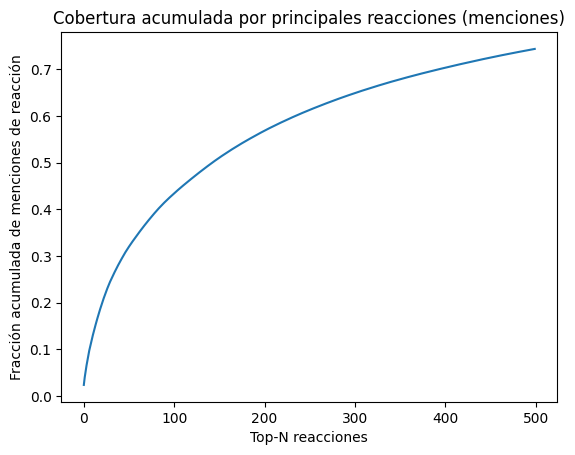

In [27]:
# Cobertura acumulada Top-N reacciones sobre reportes
cum = top_reac.cumsum() / top_reac.sum()
plt.figure()
plt.plot(cum.values[:500])
plt.xlabel("Top-N reacciones")
plt.ylabel("Fracción acumulada de menciones de reacción")
plt.title("Cobertura acumulada por principales reacciones (menciones)")
plt.show()

### Cobertura acumulada por Top-N reacciones (menciones)

La curva de **cobertura acumulada** confirma una distribución de **cola larga**: las reacciones más frecuentes explican una fracción grande de las menciones, pero la cobertura crece cada vez más lento conforme aumentamos N. En la muestra, incluso con **Top-500 reacciones** la cobertura llega aproximadamente a **~75%** de las menciones, lo que implica que el restante ~25% está distribuido en miles de reacciones menos frecuentes. Esto respalda el uso de **umbrales mínimos de soporte** (conteos mínimos) al buscar señales, para evitar resultados dominados por eventos muy raros.

### Datos de contexto

Se hace Datos de contexto (campos en reports como occurcountry y receiptdate) para validar el dataset y para poder estratificar e interpretar señales sin mezclar cosas heterogéneas.


Top-10 occurcountry:


occurcountry
US    61681
CA     7507
JP     4141
FR     3591
GB     3452
DE     1893
CN     1826
IT     1095
ES     1048
AU      897
Name: count, dtype: Int64


Parsed receiptdate valid fraction: 1.0


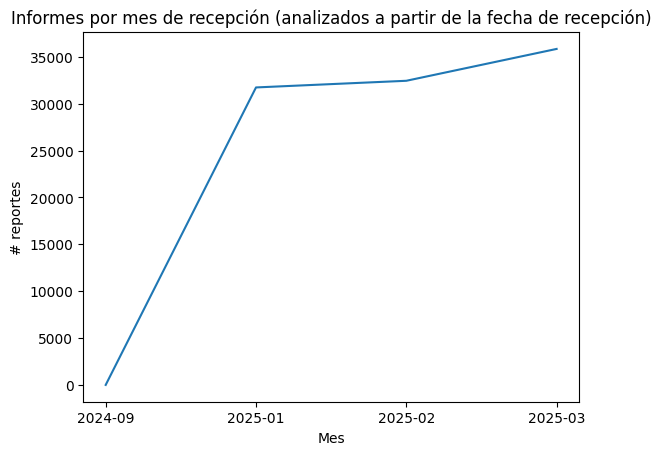

In [29]:
if "occurcountry" in reports.columns:
    print("\nTop-10 occurcountry:")
    display(reports["occurcountry"].astype("string").str.strip().str.upper().value_counts().head(10))

# receiptdate (si está en formato YYYYMMDD o similar)
if "receiptdate" in reports.columns:
    r = reports["receiptdate"].astype("string").str.strip()
    # intenta parsear YYYYMMDD; si falla queda NaN
    dt = pd.to_datetime(r, format="%Y%m%d", errors="coerce")
    print("\nParsed receiptdate valid fraction:", dt.notna().mean())
    if dt.notna().any():
        counts = dt.dt.to_period("M").value_counts().sort_index()
        plt.figure()
        plt.plot(counts.index.astype(str), counts.values)
        plt.xlabel("Mes")
        plt.ylabel("# reportes")
        plt.title("Informes por mes de recepción (analizados a partir de la fecha de recepción)")
        plt.xticks()
        plt.show()

### Reportes por mes de recepción

El conteo mensual basado en **`receiptdate`** muestra que la mayor parte de los reportes del trimestre se concentra en **enero–marzo de 2025**, con un volumen relativamente estable y una **tendencia ascendente hacia marzo**. Esto sugiere que el campo de fecha se está parseando correctamente y que, dentro del trimestre, el flujo de reportes no es uniforme (hay más entradas hacia el final del periodo). La presencia de un punto aislado previo (p.ej. 2024-09) indica que en FAERS pueden existir reportes recibidos fuera del rango esperado del trimestre (rezagos/actualizaciones), por lo que conviene mantener esta verificación como control de calidad.


### Distribución geográfica (occurcountry)

La tabla **Top-10 `occurcountry`** muestra un claro predominio de **US (≈61,681 reportes)**, seguido por **CA, JP, FR, GB, DE, CN, IT, ES y AU**. Esto es consistente con el hecho de que FAERS es un sistema con fuerte contribución de EE. UU., pero con participación internacional relevante. Esta asimetría sugiere que, si más adelante se comparan señales entre países o regiones, será importante considerar el tamaño muestral y posibles diferencias en prácticas de reporte.

Resumen del análisis:

* IDs completos y consistentes.
* `activesubstancename` con **98.4%** de cobertura (excelente).
* Cola larga esperada en reacciones (normal en FAERS).
* Outliers existen pero son raros (según percentiles).

